In [1]:
import os
import math
import openturns as ot
import scipy.stats as stats
from scipy.optimize import minimize
import numpy as np
import openturns.viewer as viewer
from joblib import Parallel, delayed

from matplotlib import pylab as plt
from matplotlib import cm
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection

import otaf
import matplotlib.path as mpltPath


In [2]:
%matplotlib inline

s2 = math.sqrt(2)

# Process capabilities

In [3]:
def calculate_sigma(mu, a, b, P):
    """
    Calculate the standard deviation of a normal distribution given
    the mean, the lower limit, the upper limit, and the probability.
    
    Parameters:
    mu (float): Mean of the distribution.
    a (float): Lower limit (a <= 0).
    b (float): Upper limit (b >= 0).
    P (float): Probability of being below a or above b (a < mu < b).
    
    Returns:
    float: The standard deviation.
    """
    assert a <= 0, "Lower limit a must be less than or equal to 0."
    assert b >= 0, "Upper limit b must be greater than or equal to 0."
    assert a < mu < b, "Mean mu must be between a and b."
    assert 0 < P < 1, "Probability P must be between 0 and 1 (exclusive)."
    
    # Calculate tail probabilities
    tail_prob = P / 2
    
    # Calculate the z-scores for the given tail probabilities
    z_low = stats.norm.ppf(tail_prob)
    z_high = stats.norm.ppf(1 - tail_prob)
    
    # Calculate sigma using the nearest bound to the mean
    if abs(mu - a) < abs(mu - b):
        sigma = (a - mu) / z_low
    else:
        sigma = (b - mu) / z_high
    
    sigma = abs(sigma)
    
    # Calculate the actual probabilities with this sigma
    prob_below_a = stats.norm.cdf(a, mu, sigma)
    prob_above_b = 1 - stats.norm.cdf(b, mu, sigma)
    
    # Adjust sigma if the probabilities do not sum to the desired P
    total_prob = prob_below_a + prob_above_b
    if abs(total_prob - P) > 1e-9:
        if prob_below_a > prob_above_b:
            z_adjusted = stats.norm.ppf(tail_prob * (P / total_prob))
            sigma = abs((a - mu) / z_adjusted)
        else:
            z_adjusted = stats.norm.ppf(1 - tail_prob * (P / total_prob))
            sigma = abs((b - mu) / z_adjusted)
    
    return sigma

def get_cp_cpk_cm_normal(mu, sigma, lb, ub, center=0):
    cp = (ub-lb)/(6*sigma)
    cpk = min((ub-mu)/(3*sigma), (mu-lb)/(3*sigma))
    cpm = (ub-lb)/(6*math.sqrt(sigma**2+(mu - center)**2))
    return cp, cpk, cpm

def plot_distribution_with_bounds(mu, sigma, lb, ub, center=0):
    # Compute cp, cpk, cpm
    cp, cpk, cpm = get_cp_cpk_cm_normal(mu, sigma, lb, ub, center)
    
    # Generate data points for the normal distribution
    x = np.linspace(lb, ub, 10000)
    y = stats.norm.pdf(x, mu, sigma)
    
    # Calculate the probability of being out of bounds
    prob_lb = stats.norm.cdf(lb, mu, sigma)
    prob_ub = 1 - stats.norm.cdf(ub, mu, sigma)
    prob_out_of_bounds = prob_lb + prob_ub
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    
    # Fill the background for out of bounds regions with light gray hatch
    plt.axvspan(-100, lb, color='lightgray', alpha=0.3, hatch='//')
    plt.axvspan(ub, 100, color='lightgray', alpha=0.3, hatch='//')
    
    plt.plot(x, y, label='Normal Distribution')
    
    # Plot lower and upper bounds
    plt.axvline(lb, color='red', linestyle='--', label=f'Lower Bound (lb={lb})')
    plt.axvline(ub, color='green', linestyle='--', label=f'Upper Bound (ub={ub})')
    
    # Plot the nominal centered value
    plt.axvline(center, color='blue', linestyle=':', label=f'Target (center={center})')
    
    # Annotate cp, cpk, cpm values
    informative_text = (f'$C_p = {cp:.2f}$\n'
                        f'$C_{{pk}} = {cpk:.2f}$\n'
                        f'$C_{{pm}} = {cpm:.2f}$\n'
                        f'$P_{{out}} = {prob_out_of_bounds:.2E}$')
    plt.text(0.7, 0.95, informative_text, transform=plt.gca().transAxes,
             horizontalalignment='left', verticalalignment='top', fontsize=12,
             bbox=dict(facecolor='white', alpha=0.5))
    
    # Add labels and title
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title('Normal Distribution with Bounds, Target, Capabilities and Out of Bounds Probability')
    plt.legend(loc=(0.13,0.75))
    
    # Highlight the areas out of bounds
    x_fill_left = np.linspace(mu - 4*sigma, lb, 1000)
    y_fill_left = stats.norm.pdf(x_fill_left, mu, sigma)
    plt.fill_between(x_fill_left, y_fill_left, color='red', alpha=0.6)
    
    x_fill_right = np.linspace(ub, mu + 4*sigma, 1000)
    y_fill_right = stats.norm.pdf(x_fill_right, mu, sigma)
    plt.fill_between(x_fill_right, y_fill_right, color='green', alpha=0.6)
    
    # Show the plot
    plt.grid(True)
    plt.xlim(lb*1.2, ub*1.2)
    plt.show()


def plot_cp_cpk_cpm(a, b, P, y_lim=4):
    # Center of the target
    center = 0
    
    # Generate a range of mu values
    mu_values = np.linspace(a + 0.01, b - 0.01, 10000)

    # Function to calculate Cp, Cpk, and Cpm for a given mu
    def compute_indices(mu):
        sigma = calculate_sigma(mu, a, b, P)
        cp, cpk, cpm = get_cp_cpk_cm_normal(mu, sigma, a, b, center)
        return cp, cpk, cpm

    # Use joblib to parallelize the computation
    results = Parallel(n_jobs=-1)(delayed(compute_indices)(mu) for mu in mu_values)

    # Unzip the results into separate lists
    cp_values, cpk_values, cpm_values = zip(*results)

    # Convert lists to arrays for plotting
    cp_values = np.array(cp_values)
    cpk_values = np.array(cpk_values)
    cpm_values = np.array(cpm_values)

    # Plot the results
    plt.figure(figsize=(12, 8))
    plt.plot(mu_values, cp_values, label='$C_p$')
    plt.plot(mu_values, cpk_values, label='$C_{pk}$')
    plt.plot(mu_values, cpm_values, label='$C_{pm}$')
    plt.xlabel('Mean Shift ($\mu$)')
    plt.ylabel('Capability Indices')
    plt.title('Capability Indices vs Mean Shift')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, y_lim)
    plt.show()

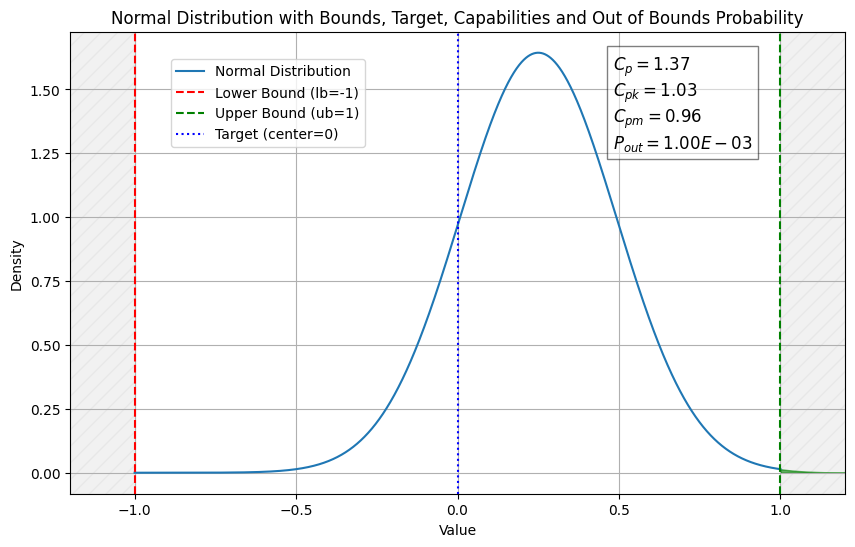

In [4]:
lb, ub = -1, 1
mu = 0.25
P = 1e-3
ss = calculate_sigma(mu, lb, ub, P)
plot_distribution_with_bounds(mu, ss, lb, ub, 0)

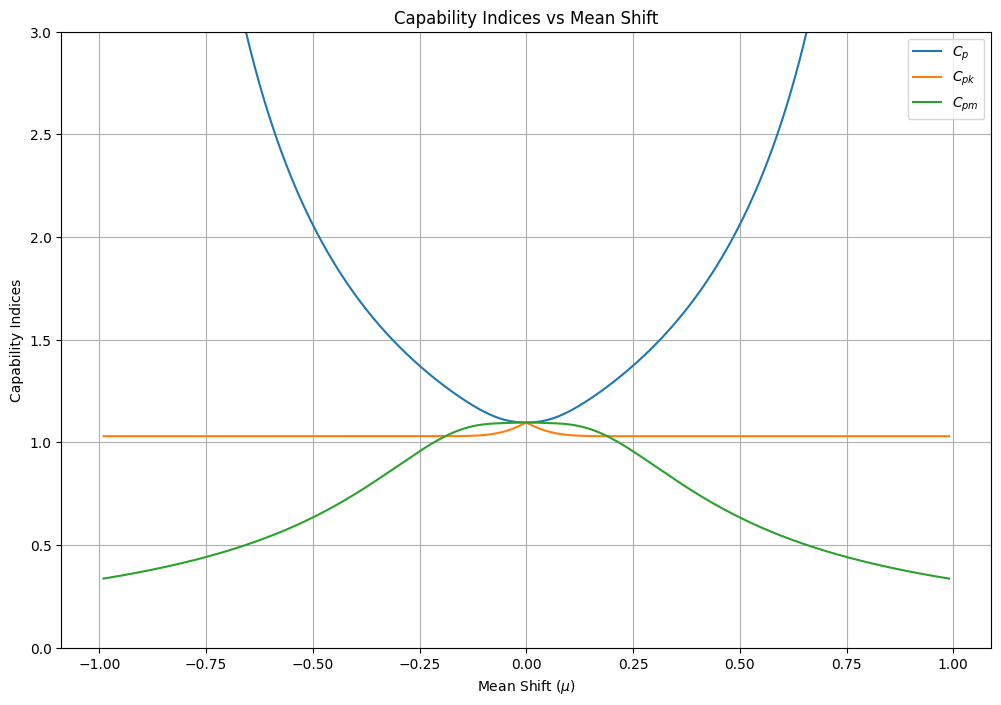

In [5]:
plot_cp_cpk_cpm(lb, ub, P, 3)

# Some scripts for plotting nice images for the publications / thesis

#### Imprecision in the deviation domain with (hopefully) constant failure probability

In [6]:
X1 = ot.Normal(0,s2/6)
X2 = ot.Normal(0,s2/6)
XCOMP = ot.ComposedDistribution([X1,X2])

lim1 = [-1,1]
lim2 = [-1,1]

lim_polygon = [[lim1[0], 0], [0, lim2[1]], [lim1[1], 0], [0, lim2[0]]]
path = mpltPath.Path(lim_polygon)

N = 10000

In [7]:
smp1 = np.array(XCOMP.getSample(N))*np.array([.49**(1/2), .51**(1/2)])
smp2 = np.array(XCOMP.getSample(N))*np.array([.7**(1/2), .3**(1/2)])
smp3 = np.array(XCOMP.getSample(N))*np.array([.001**(1/2), .999**(1/2)])

smp0 = XCOMP.getSample(N)
smp1 = np.array(smp0)*np.array([.49**(1/2), .51**(1/2)])
smp2 = np.array(smp0)*np.array([.96**(1/2), .04**(1/2)])
smp3 = np.array(smp0)*np.array([.01**(1/2), .99**(1/2)])

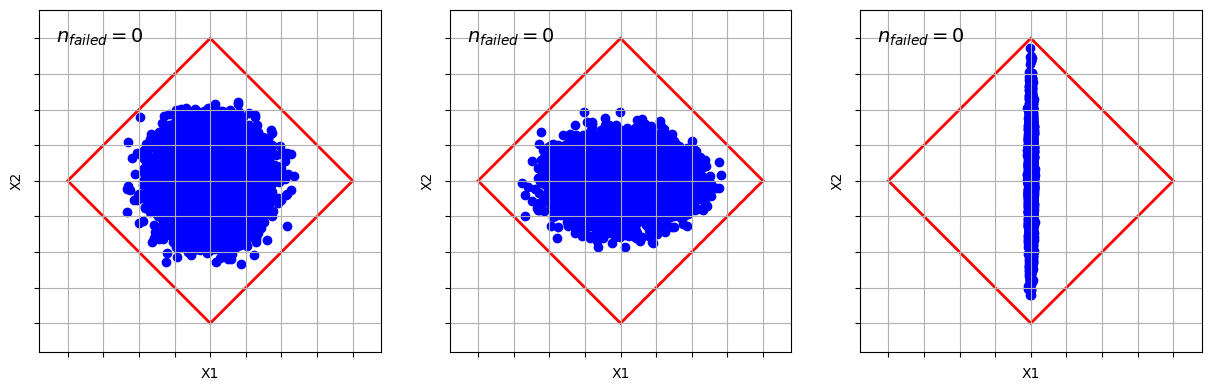

In [8]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))  # Adjust figsize as needed
ax1 = otaf.plotting.plot_deviation_domain(ax1, smp1, 'X1', "X2", x_bounds=lim1, y_bounds=lim2, ratio_bounds=1.2)
ax2 = otaf.plotting.plot_deviation_domain(ax2, smp2, 'X1', "X2", x_bounds=lim1, y_bounds=lim2, ratio_bounds=1.2)
ax3 = otaf.plotting.plot_deviation_domain(ax3, smp3, 'X1', "X2", x_bounds=lim1, y_bounds=lim2, ratio_bounds=1.2)